# **Computer Lab : Natural Language Processing - Hugo Queniat**

In [1]:
#imports

import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy.sparse as sp
import matplotlib.pyplot as plt
import tp_reglog_utils as utils
from scipy.optimize import check_grad


## **3 Tikhonov regularization**

### **Question 3.1**

$$f_1 : (w_0, w) \mapsto \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i(x_i^T w + w_0))) + \frac{\rho}{2} \|w\|_2^2$$

Let $\hat{w} = (w, w_0)^T$ and $\hat{x_i} = (x_i, 1)^T$ for all $i$.

Then, we have $$f_1 : \hat{w} \mapsto \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i(\hat{x_i}^T \hat{w}))) + \frac{\rho}{2} \|w\|_2^2$$

Through computations, we find first for the gradient :

$$\nabla f_1(\hat{w}) = \frac{1}{n} \sum_{i=1}^{n} \dfrac{-y_i \hat{x_i} \exp(-y_i \hat{x_i}^T \hat{w})}{1 + \exp(-y_i \hat{x_i}^T \hat{w})} + \rho w$$

Finally, for the hessian matrix :

$$\nabla^2 f_1(\hat{w}) = \frac{1}{n} \sum_{i=1}^{n} \dfrac{\exp(-y_i \hat{x_i}^T \hat{w})}{\left(1 + \exp(-y_i \hat{x_i}^T \hat{w})\right)^2} \hat{x_i} \hat{x_i}^T + \rho I_{p+1}$$

The hessian matrix is a positive definite matrix: the 1st term is a semi-definite positive matrix as it is of the form $U.U^T$ while the second term makes sure to have strictly positive eigenvalues since $\rho > 0$.
Thus, $f_1$ is a convex function.

### **Question 3.2**

In [2]:
#function f1

def f1(what):
    S = [y[i] * xhat[i].T @ what for i in range(n)]
    rho = 1/n
    sum = 0
    for i in range(n):
        sum += np.log(1 + np.exp(-S[i]))
    return (1 / n) * sum + (rho / 2) * (np.linalg.norm(what[:-1], 2) ** 2)


In [3]:
#gradient f1

def gradient_f1(what):
    S = [y[i] * xhat[i].T @ what for i in range(n)]
    rho = 1/n
    sum = 0
    for i in range(n):
        sum += (-y[i] * xhat[i].T) / (1 + np.exp(S[i]))
    return (1 / n) * sum + rho * np.concatenate([what[:-1], [0]])


In [4]:
#hessian f1

def hessian_f1(what):
    S = [y[i] * xhat[i].T @ what for i in range(n)]
    rho = 1 / n
    sum = 0
    for i in range(n):
        sum += ((np.exp(S[i])) / ((1 + np.exp(S[i])))**2) * np.outer(xhat[i],xhat[i].T)
    return (1 / n) * sum + rho * np.eye(p + 1)


In [66]:
#Testing gradient
n = 10
p = 10
xhat = np.random.randn(n, p + 1)
y = np.random.randn(n)

def check_gradient():
	w0 = np.random.randn(1)
	w = np.random.randn(p)
	what = [np.concatenate([w0, w]) for _ in range(100)]
	print(np.max([check_grad(f1, gradient_f1, u) for u in what]))

check_gradient()

2.8603864726817352e-08


In [73]:
#Testing hessian

def check_hess(grad_f, hess_f, x0):
    return check_grad(lambda x: grad_f(x)[0], lambda x: hess_f(x)[:,0], x0)

check_hess(gradient_f1, hessian_f1, np.random.randn(p + 1))

0.20443930255565548

The two functions seem to work well according to the verifications done with scipy. since there is only a small error.

### **Question 3.3**

In [165]:
# Load data

eX, y, eX_test, y_test = utils.load_data()

n = eX.shape[0]
p = eX.shape[1] - 1
xhat = np.roll(eX, -1, axis=1)

In [257]:
# Newton's method

def newton(what, f=f1, grad_f=gradient_f1, hess_f=hessian_f1, max_iter=200, err=1e-10, armijo=False):
    # lists to store norms of gradient and function values
    grad_norms , values = [] , []
    for i in range(max_iter):
        # evaluate function and its gradient and Hessian at current point
        value , grad, hess = f(what) , grad_f(what), hess_f(what)
        norm = np.linalg.norm(grad, 2)
        grad_norms.append(norm)
        values.append(value)
        # check stopping condition
        if norm < err:
            break
        # update direction
        d = - np.linalg.solve(hess, grad)
        if armijo:
            what += armijo_line_search(what, grad, value, d)
        else:
            what += d
    # create plots for gradient norms and function values
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
    ax0.plot(grad_norms)
    ax0.set_yscale("log")
    ax0.set_xlabel("step number", fontsize=12)
    ax0.set_ylabel("Gradient", fontsize=12)
    ax1.plot(values)
    ax1.set_yscale("log")
    ax1.set_xlabel("step number", fontsize=12)
    ax1.set_ylabel("Value of function", fontsize=12)
    plt.show()


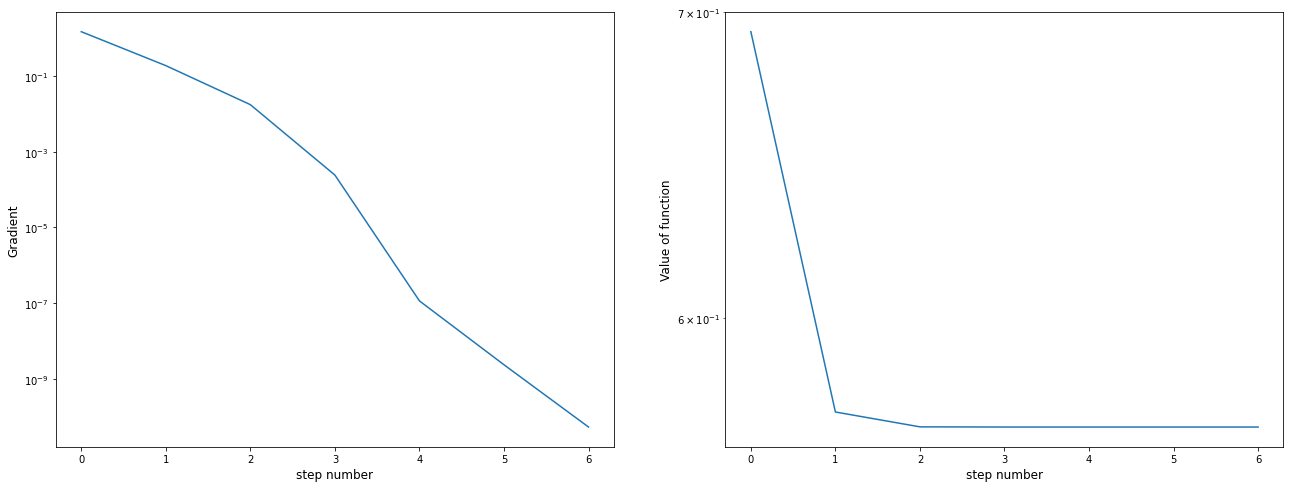

In [31]:
#Initial point 0

what = np.zeros(p + 1)
newton(what)

### **Question 3.4**

<ipython-input-4-446430831058>:8: RuntimeWarning: overflow encountered in double_scalars
  sum += ((np.exp(S[i])) / ((1 + np.exp(S[i])))**2) * np.outer(xhat[i],xhat[i].T)
<ipython-input-2-e3f18ebaa297>:8: RuntimeWarning: overflow encountered in exp
  sum += np.log(1 + np.exp(-S[i]))
<ipython-input-4-446430831058>:8: RuntimeWarning: invalid value encountered in double_scalars
  sum += ((np.exp(S[i])) / ((1 + np.exp(S[i])))**2) * np.outer(xhat[i],xhat[i].T)


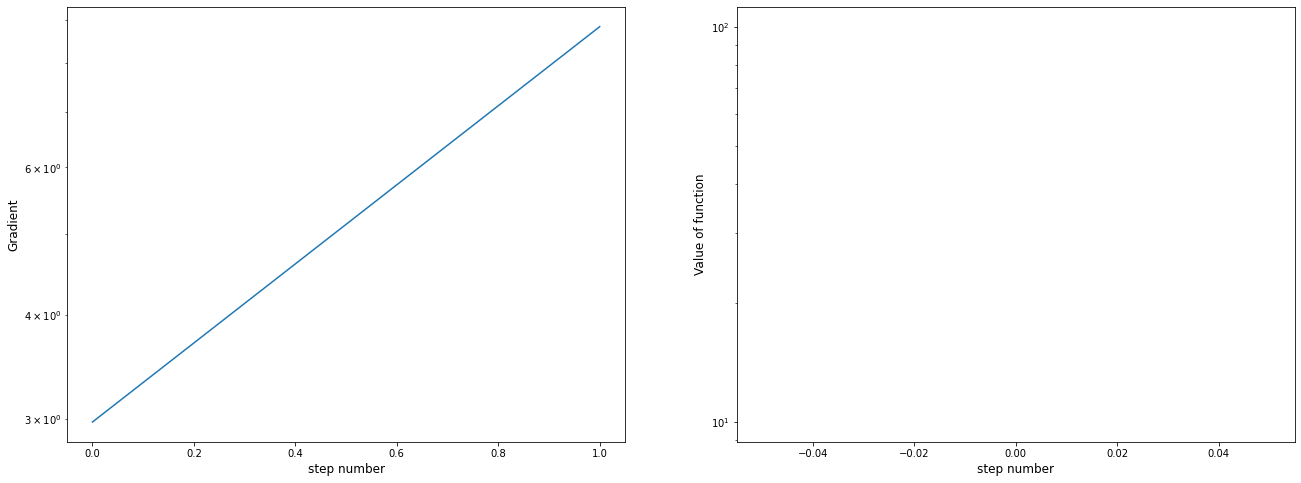

In [32]:
#Initial point 1

what = np.ones(p + 1)
newton(what)

The algorithm does not converge.

### **Question 3.5**

I chose the classical parameters with $a=\frac{1}{2}, b=1$ and for $\beta$ I searched what would be a classical value.

In [35]:
#Armijo

def armijo_line_search(what,  grad, value, d, a=0.5, b=1, beta=0.01, f=f1):
    # initial step size
    gamma = b
    # check the Armijo condition
    while f(what + gamma * d) > value + beta * gamma * grad.T @ d:
        # decrease step size
        gamma *= a
    return gamma * d

<ipython-input-33-281040e44080>:8: RuntimeWarning: overflow encountered in double_scalars
  sum += np.outer(xhat[i],xhat[i].T) * ((np.exp(S[i])) / ((1 + np.exp(S[i])))**2)
<ipython-input-31-201d1aacd82e>:8: RuntimeWarning: overflow encountered in exp
  sum += np.log(1 + np.exp(-S[i]))


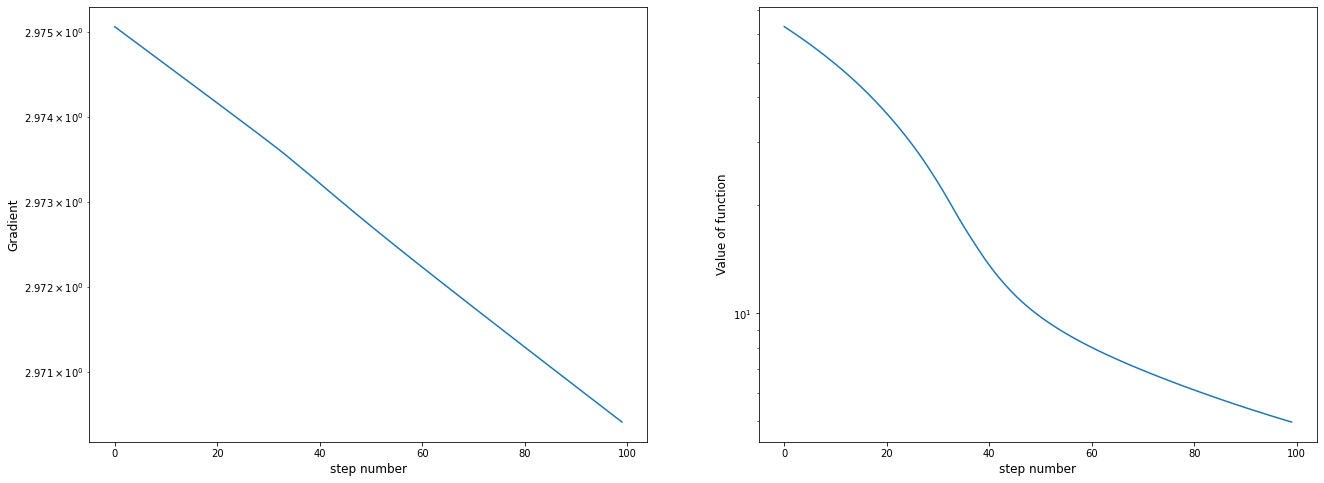

In [62]:
#Initial point 1 with Armijo

what = np.ones(p + 1)
newton(what, armijo=True)

With the line search, the algorithm works perfectly. 

## **4 Regularization for a sparse model**

### **Question 4.1**

The function is not $\mathcal{C}^3$ anymore because of the non-differentiability of $\|\|_1$. As a result, we can no longer apply Newton's method.

### **Question 4.2**

By staying with the same notations as in the previous part,

We have $F_2 = f_2 + g_2 $, with 

$$f_2 : \hat{w} \mapsto \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i(\hat{x_i}^T \hat{w})))$$

and,

$$ g_2 : (w, w_0) \mapsto   \rho \|w\|_1$$

By simple computation, we then find that,

$$\mathrm{prox}_{g_2}(w,w_0) = \argmin_{y \in \mathbb{R}^{p+1}} {g_2(y) + \frac{1}{2} \|y-(w, w_0)\|_2^2} = (\mathrm{sign}(w_1)\max(|w_1| - \rho,0), ... , \mathrm{sign}(w_p)\max(|w_p| - \rho,0), w_0)$$

Furthermore, according to part 3 : 

$$\nabla f_2(\hat{w}) = \frac{1}{n} \sum_{i=1}^{n} \dfrac{-y_i \hat{x_i} \exp(-y_i \hat{x_i}^T \hat{w})}{1 + \exp(-y_i \hat{x_i}^T \hat{w})}

### **Question 4.3**

In [231]:
# Function F2

def F2(what):
    return f2(what) + g2(what)

In [213]:
# Function f2

def f2(what):
    S = [y[i] * xhat[i].T @ what for i in range(n)]
    sum = 0
    for i in range(n):
        sum += np.log(1 + np.exp(-S[i]))
    return sum/n

In [214]:
# Function g2

def g2(what, rho=0.02):
    return rho*np.linalg.norm(what[:-1],1)

In [215]:
# Gradient of f2

def grad_f2(what):
    S = [y[i] * xhat[i].T @ what for i in range(n)]
    sum = 0
    for i in range(n):
        sum += (-y[i] * xhat[i].T) / (1 + np.exp(S[i]))
    return sum/n

In [228]:
# Proximal operator of g2

def proximal_op_g2(what, rho):
    return np.sign(what) * np.maximum(np.abs(what) - rho, 0)

In [248]:
# Taylor Line Search

def line_search(what, grad, value, prox_op=proximal_op_g2, a=0.5, b=1, beta=0.01, rho=0.02,f=f2):
	# initial step size
	gamma = b
	# direction
	d = - grad
	# update point
	w0 = prox_op(what - gamma * grad, gamma*rho)
	# check the Armijo condition
	while f(w0) > value + grad @ (w0-what) + 0.5 * (1/gamma) * (np.linalg.norm(w0-what, 2)**2):
		# decrease step size
		gamma *= a
		w0 = prox_op( what - gamma * grad, gamma*rho )
	return w0


In [258]:
# Proximal Gradient

def prox_grad(what, F=F2, f=f2, grad_f=grad_f2, prox_op=proximal_op_g2, max_iter=200, err=1e-8, rho=0.02):
    # lists to store norms of gradient and function values
    values = []
    for i in range(max_iter):
        # evaluate function and its gradient and Hessian at current point
        value , grad = F(what) , grad_f(what)
        values.append(value)
        # find a new direction
        wnew = line_search(what, grad, f(what), prox_op=prox_op, rho=rho, f=f)
        # check stopping condition
        if np.linalg.norm(wnew- what,2)**2 < err:
            break
        # update direction
        what = wnew
    # create plots for gradient norms and function values
    plt.figure(figsize=(10, 8))
    plt.plot(values)
    plt.title("Evolution of Function values over Iterations")
    plt.xlabel("Iteration number")
    plt.yscale("log")
    plt.ylabel("Function value")
    plt.show()
    return F(what)



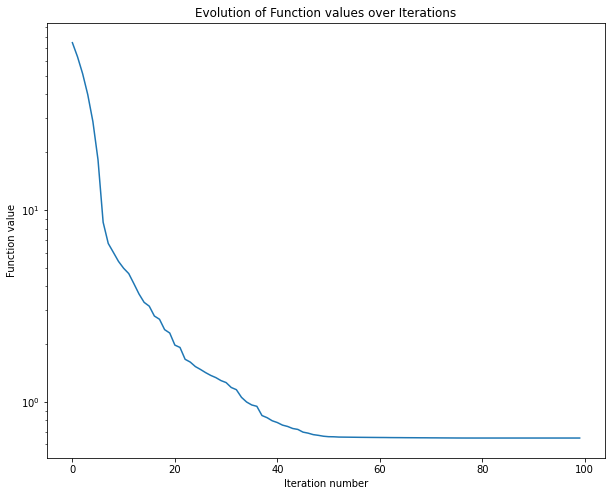

0.6472421423331154

In [259]:
#Initial point 1

what = np.ones(p + 1)
prox_grad(what)

Here I chose as a stopping criterion the fact that two points should be too close to one another, it seems to work well

In [ ]:
# random initial point

what = np.random.rand(p + 1)